In [1]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
import pandas as pd
import numpy as np
import random
import os
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
import time
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams['axes.unicode_minus']=False

path = 'result/Mackey-Glass'
if not os.path.exists(path):
    os.makedirs(path)
    

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))

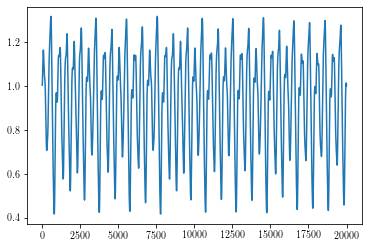

In [2]:
Y0 = np.loadtxt('dataset/matlab_gendata/MackeyGlass.csv', delimiter=',').T
# Y0 = np.array([np.sin(0.01*t) for t in range(20000)])
plt.plot(Y0)

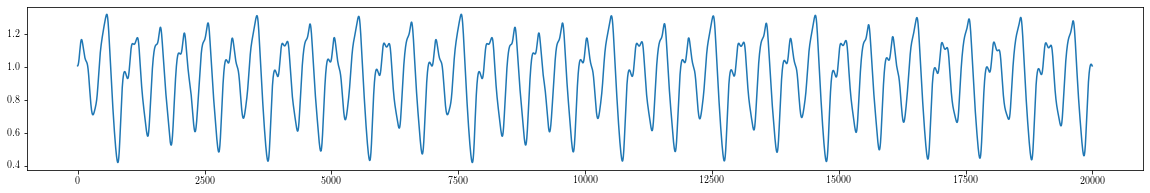

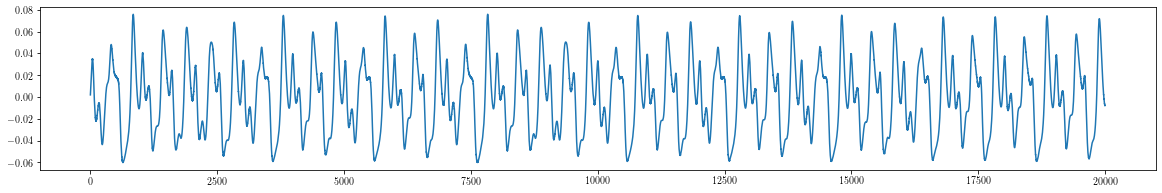

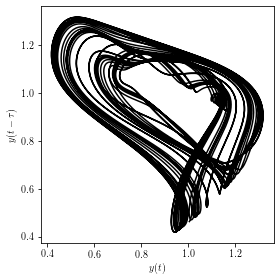

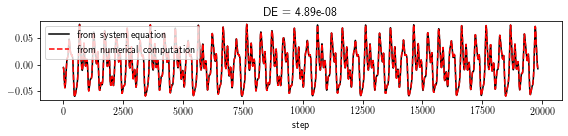

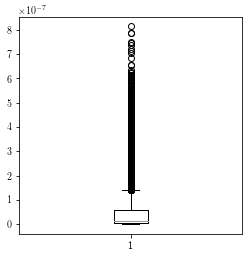

In [12]:


def examine(Y0, h=0.1):
    def daoshu(x, h):
        return x[2:-2], (x[:-4] - 8* x[1:-3] + 8* x[3:-1] - x[4:])/(12*h)
    
    n_delay = int(17/h)
    Y1, Y1d = daoshu(Y0, h)
    plt.figure(figsize=(20,3))
    plt.plot(Y1)
    plt.figure(figsize=(20,3))
    plt.plot(Y1d)
    Y_delay = Y1[:-n_delay]
    Y = Y1[n_delay:]
    Yd = Y1d[n_delay:]
    plt.figure(figsize=(4,4))
    plt.plot(Y,Y_delay, 'k')
    plt.xlabel(r'$y(t)$')
    plt.ylabel(r'$y(t-\tau)$')
    plt.tight_layout()

    a=0.2;
    b=0.1;
    c=10;

    Ydd = a * Y_delay / (1+Y_delay**c) - b*Y
    plt.figure(figsize=(8,2))
    plt.plot(Ydd, 'k', label='from system equation')
    plt.plot(Yd,'r--', label='from numerical computation')
    plt.xlabel('step')
    plt.legend(loc='upper left')
    plt.title('DE = {:.3g}'.format(np.average(np.square(Ydd-Yd))))
    plt.tight_layout()
#     plt.savefig(path+'/MG-attractor-error.pdf')
    fig, ax = plt.subplots(figsize=(4,4))
#     ax.violinplot(np.square(Ydd-Yd),
#                showmeans=False,
#                showmedians=True,
#               showextrema=False,
#               quantiles=[[0.25,0.5,0.75]]
#                )
    ax.boxplot(np.square(Ydd-Yd))
#     ax.set_yscale('log')
    plt.show()

examine(Y0)

In [5]:
def black_box(a, K, inputscaling, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    X_test = X[:,test_start : test_start + num_test]
    err = Y_test - Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
#     print(err)
    err = np.min(np.average(np.square(err), axis=1))
    return -np.log10(err)

def multistep_prediction(a, K, inputscaling, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])

    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    horizon = 100
    mse = []
    for h in range(horizon):
        if h == 0:
            U_test = U[:,test_start : test_start + num_test]
            X_test = X[:,test_start : test_start + num_test]
        else:
            U_test = Y_pred[dim] 
            X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )

        H = np.vstack((np.ones((1,num_test)),X_test))
        Y_pred = Wout @ H
        Y_true = Y[dim,test_start+h+1 : test_start + num_test + h+1]
        err = np.min(np.average(np.square(Wout @ H - Y_true), axis=1))
        mse.append(err)
    with open(path+'/multi-pred result.csv', 'w') as file:
        file.write(','.join([str(e) for e in mse]) + '\n')
    plt.figure()
    plt.plot(mse) 
    plt.yscale('log')
    plt.show()
    
def multistep_prediction_attn(a, K, inputscaling, beta, N_c = 100, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x
    X_train = X[:,train_start : train_start + num_train]  
    Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
    tau = svht(X_train, sv=Diag)
    N_v = np.sum(Diag>tau)
    MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]
    Cs = clustering((np.diag(Diag)@ Mr).T, N_c)  # N_c, N_v
    S = np.exp(- 2**beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
    H = np.vstack((np.ones((1,num_train)), X_train, S))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    X_test = X[:,test_start : test_start + num_test]
    horizon = 100
    mse = []
    for h in range(horizon):
        if h == 0:
            U_test = U[:,test_start : test_start + num_test]
            X_test = X[:,test_start : test_start + num_test]
        else:
            U_test = Y_pred[dim] 
            X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )

        S = np.exp( - 2**beta* pairwise_distances(Cs, (MlT @ X_test).T))
        H = np.vstack((np.ones((1,num_test)), X_test, S))
        Y_pred = Wout @ H
        Y_true = Y[dim,test_start+h+1 : test_start + num_test + h+1]
        err = np.min(np.average(np.square(Wout @ H - Y_true), axis=1))
        mse.append(err)
    plt.figure()
    plt.plot(mse) 
    plt.yscale('log')
    plt.show()
    
def pairwise_distances(X, Y):
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0
    return D

def clustering(data, N_c):
    estimator = KMeans(init='random', n_clusters=N_c, n_init=3)
    estimator.fit(data)
    return estimator.cluster_centers_

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    def omega_approx(beta):
        """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        """Return lambda star for given beta. Equation (11) from Gavish 2014."""
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

from functools import partial
def partial_black_box_attn(beta):
    reg=1e-6
    S = np.exp(- 2**beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
    H = np.vstack((np.ones((1,num_train)), X_train, S))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    S = np.exp( - 2**beta* pairwise_distances(Cs, (MlT @ X_test).T))
    H = np.vstack((np.ones((1,num_test)), X_test, S))
    err = np.min(np.average(np.square(Wout @ H - Y_test), axis=1))
    return -np.log10(err)

U shape: (1, 20000)
Y shape: (1, 20000)
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  1        |  6.093    |  1.124    |  0.9507   |  2.196    |
|  2        |  6.487    |  1.796    |  0.156    |  0.468    |
|  3        |  5.804    |  0.1743   |  0.8662   |  1.803    |
|  4        |  5.995    |  2.124    |  0.02058  |  2.91     |
|  5        |  6.689    |  2.497    |  0.2123   |  0.5455   |
|  6        |  6.248    |  0.5502   |  0.3042   |  1.574    |
|  7        |  6.333    |  1.296    |  0.2912   |  1.836    |
|  8        |  6.215    |  0.4185   |  0.2921   |  1.099    |
|  9        |  6.213    |  1.368    |  0.7852   |  0.599    |
|  10       |  6.353    |  1.543    |  0.5924   |  0.1394   |
|  11       |  6.53     |  1.823    |  0.1705   |  0.1952   |
|  12       |  6.2      |  2.847    |  0.9656   |  2.425    |
|  13       |  6.392    |  0.9138   |  0.09767  |  2.053    |
|  14       |  6.426    |  1.3

|  80       |  6.823    |  2.603    |  0.1066   |  0.6052   |
|  81       |  6.7      |  2.485    |  0.1065   |  0.7365   |
|  82       |  6.615    |  2.373    |  0.1461   |  0.6831   |
|  83       |  6.791    |  2.735    |  0.1081   |  0.7508   |
|  84       |  6.645    |  2.664    |  0.262    |  0.5271   |
|  85       |  6.557    |  2.434    |  0.03428  |  0.7172   |
|  86       |  6.344    |  1.577    |  0.219    |  2.799    |
|  87       |  6.871    |  2.827    |  0.08034  |  0.7368   |
|  88       |  6.642    |  2.808    |  0.2035   |  0.7754   |
|  89       |  6.844    |  2.879    |  0.1393   |  0.7095   |
|  90       |  6.646    |  2.669    |  0.2627   |  0.5312   |
|  91       |  6.814    |  2.837    |  0.0435   |  0.8268   |
|  92       |  6.248    |  0.362    |  0.1577   |  1.4      |
|  93       |  6.361    |  1.548    |  0.5025   |  0.2247   |
|  94       |  6.749    |  2.887    |  0.1478   |  0.7823   |
|  95       |  6.838    |  2.913    |  0.04955  |  0.7568   |
|  96   

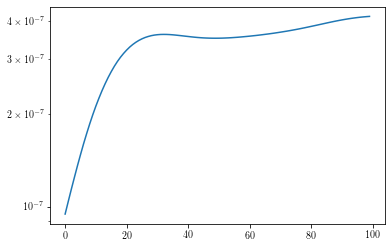

In [6]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer


dim = [0]
Y = np.atleast_2d(Y0)
U0 = Y
U = U0 + np.random.randn(*U0.shape)*1e-3
U = np.atleast_2d(U)

num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 0
test_start = num_prepare + num_train + num_val
num_test = 8000
print('U shape:', U.shape)
print('Y shape:', Y.shape)


inSize = U.shape[0]
outSize = inSize 
resSize = 300

U_train = U[:,train_start : train_start + num_train]
Y_train = Y[dim,train_start + 1 : train_start + num_train + 1]
Y_test = Y[dim,test_start + 1 : test_start + num_test + 1]

seed = 42
random.seed(seed) 
np.random.seed(seed)
Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
W0 = np.random.rand(resSize,resSize)-0.5
largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])


# Bounded region of parameter space
pbounds = {
    'a': (0, 1), 
    'K': (0, 3),
    'inputscaling': (0,3),
}

#     bounds_transformer = SequentialDomainReductionTransformer()


optimizer = BayesianOptimization(
    f=black_box,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=seed,
#         bounds_transformer=bounds_transformer
)

#     optimizer.probe(
#         params=[0.1,1.9,1.0,1e-6],
#         lazy=True,
#     )


# optimizer.maximize(
#     init_points=30,
#     n_iter=100,
#     acq="ucb", kappa=10, kappa_decay=0.95
# )  
optimizer.maximize(
    init_points=30,
    n_iter=100,
    acq="ei", xi=1e-4
)

print(optimizer.max)
params = optimizer.max['params']
a, K, inputscaling  = params['a'], params['K'], params['inputscaling']

multistep_prediction(a, K, inputscaling)


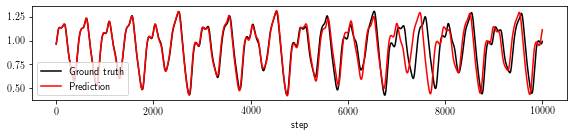

In [7]:
reg = 1e-6
W = W0/rhoW*K 
Win = Win0*inputscaling
X = np.zeros((resSize,U.shape[1]))
x = np.zeros([resSize,1])

for t in range(U.shape[1]):
    u = U[:,t:t+1]
    x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
    X[:,t:t+1] = x

X_train = X[:,train_start : train_start + num_train]
H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

horizon = 10000
num_test = 1
test_start = 8000
pred = []
for h in range(horizon):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred[dim] 
        X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )

    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    pred.append(Y_pred[0])

plt.figure(figsize=(8,2))
plt.plot(Y[0,test_start : test_start + horizon],'k', label='Ground truth',)
plt.plot(pred,'red', label='Prediction') 
plt.legend(loc='lower left')
plt.xlabel('step')
plt.tight_layout()
plt.savefig(path+'/MG-multistep.pdf')
plt.show()

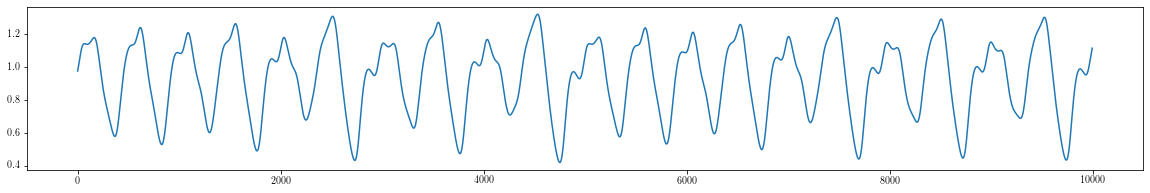

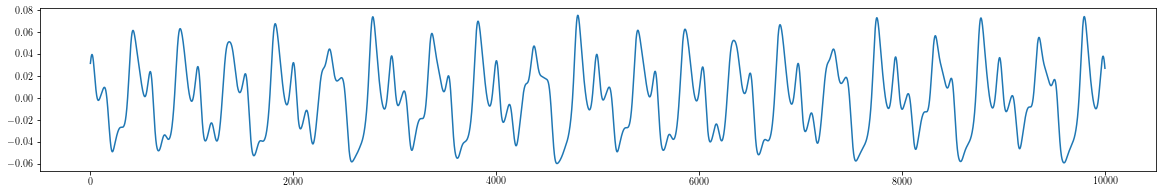

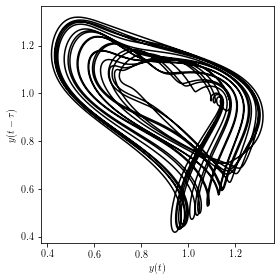

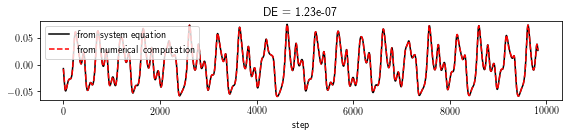

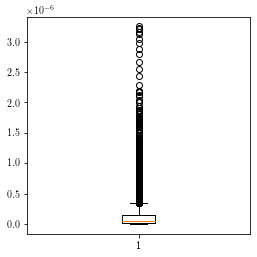

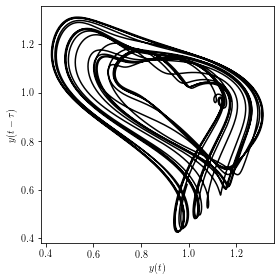

In [13]:
# examine(Y[0,test_start : test_start + horizon])
examine(np.array(pred))
plt.figure(figsize=(4,4))
plt.plot(Y[0,test_start : test_start + horizon][170:],Y[0,test_start : test_start + horizon][:-170], 'k')
plt.xlabel(r'$y(t)$')
plt.ylabel(r'$y(t-\tau)$')
plt.tight_layout()
# plt.savefig(path+'/MG-attractor-true.pdf')

In [17]:
X.shape, Y.shape

((300, 20000), (1, 20000))

In [18]:
X_train, Y_train

(array([[-0.00572364, -0.00858406, -0.0114644 , ..., -0.10302693,
         -0.10426991, -0.10546271],
        [-0.85038679, -0.85035696, -0.85032438, ..., -0.83819617,
         -0.83786079, -0.83751869],
        [-0.96847509, -0.96856314, -0.9686488 , ..., -0.97366749,
         -0.97372341, -0.97377716],
        ...,
        [-0.53919341, -0.5378053 , -0.53641758, ..., -0.49970232,
         -0.4999051 , -0.50014981],
        [-0.9669988 , -0.96703944, -0.96707929, ..., -0.97346489,
         -0.97360999, -0.97375503],
        [-0.62839771, -0.62693545, -0.62549733, ..., -0.6272299 ,
         -0.62788479, -0.62854542]]),
 array([[0.93785, 0.93933, 0.94092, ..., 1.1164 , 1.1187 , 1.1209 ]]))